In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình
import tensorflow as tf
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense, Input #đầu ra

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# đọc dữ liệu từ file exel
df = pd.read_excel('/content/gdrive/MyDrive/dataset.xlsx', sheet_name='ADD')
print(df)

        YYYY    MM    DD   TIME             STAMP   Nhiệt độ     Độ mặn  \
0        NaN   NaN   NaN    NaN               NaN        NaN        NaN   
1     2019.0   2.0   5.0  06:00  05/02/2019 06:00  18.000000  33.000000   
2     2019.0   2.0   5.0  09:00  05/02/2019 09:00  18.500000  35.000000   
3     2019.0   2.0   5.0  12:00  05/02/2019 12:00  19.000000  34.000000   
4     2019.0   2.0   5.0  15:00  05/02/2019 15:00  19.537500  33.937500   
...      ...   ...   ...    ...               ...        ...        ...   
1883  2019.0  12.0  15.0  18:00  15/12/2019 18:00  23.281250  34.937500   
1884  2019.0  12.0  16.0  00:00  16/12/2019 00:00  23.140625  34.968750   
1885  2019.0  12.0  16.0  06:00  16/12/2019 06:00  23.320312  34.984375   
1886  2019.0  12.0  16.0  09:00  16/12/2019 09:00  23.000000  35.000000   
1887  2019.0  12.0  16.0  12:00  16/12/2019 12:00  23.500000  35.000000   

           PH       NH3       H2S        TSS       DO       COD Ghi chú  \
0         NaN       NaN 

In [4]:
required_cols = ['STAMP', 'Nhiệt độ', 'Độ mặn', 'PH']
df = df[required_cols]
df.head()

df.index = pd.to_datetime(df.STAMP, format='%d/%m/%Y %H:%M')

In [5]:
for col in ['Nhiệt độ', 'Độ mặn', 'PH']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, handle errors

# Perform resampling and calculate mean for numeric columns only
df_final = df[['Nhiệt độ', 'Độ mặn', 'PH']].resample('D').mean()

# If you need 'STAMP' in the final DataFrame:
df_final['STAMP'] = df_final.index.strftime('%d/%m/%Y') # Convert datetime index back to date string
df_final.head()
print(df_final)

             Nhiệt độ     Độ mặn        PH       STAMP
STAMP                                                 
2019-02-05  18.821250  34.162500  8.092500  05/02/2019
2019-02-06  19.825521  34.458333  8.110417  06/02/2019
2019-02-07  20.942187  34.250000  8.118750  07/02/2019
2019-02-08  22.058854  34.041667  8.127083  08/02/2019
2019-02-09  23.359896  33.802083  8.137500  09/02/2019
...               ...        ...       ...         ...
2019-12-12  24.339193  34.636719  8.030339  12/12/2019
2019-12-13  24.129557  34.714844  8.053646  13/12/2019
2019-12-14  23.918620  34.777344  8.037240  14/12/2019
2019-12-15  23.509115  34.929688  8.061979  15/12/2019
2019-12-16  23.240234  34.988281  8.042187  16/12/2019

[315 rows x 4 columns]


In [6]:
temp = df_final['Nhiệt độ'].values
salinity = df_final['Độ mặn'].values
ph = df_final['PH'].values

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final[['Nhiệt độ', 'Độ mặn', 'PH']])

# Create a new DataFrame with the scaled data
scaled_df_final = pd.DataFrame(scaled_data, columns=['Nhiệt độ', 'Độ mặn', 'PH'], index=df_final.index)

In [8]:
def calculate_correlation_matrix(df, window_size):
    correlations = []
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i + window_size]
        # Only include numeric columns for correlation calculation
        corr_matrix = window[['Nhiệt độ', 'Độ mặn', 'PH']].corr(method='kendall').values  # Tính ma trận tương quan
        correlations.append(corr_matrix)
    return np.array(correlations)

window_size = 40  # Kích thước cửa sổ để tính ma trận tương quan
correlation_matrices = calculate_correlation_matrix(df_final, window_size)

In [9]:
X = correlation_matrices[:-1] # Ma trận tương quan (trừ mẫu cuối cùng)
y = df_final[['Nhiệt độ', 'Độ mặn', 'PH']].iloc[window_size:].values

In [10]:
targets = df_final[['Nhiệt độ', 'Độ mặn', 'PH']].iloc[window_size:].values

In [11]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

correlation_matrices_scaled = scaler_x.fit_transform(correlation_matrices.reshape(-1, 9)).reshape(-1, 3, 3)
targets_scaled = scaler_y.fit_transform(targets)

In [12]:
train_size = int(0.6 * len(correlation_matrices_scaled))
val_size = int(0.2 * len(correlation_matrices_scaled))
test_size = len(correlation_matrices_scaled) - train_size - val_size

# Chia dữ liệu thành Train, Validation và Test
X_train = correlation_matrices_scaled[:train_size]
y_train = targets_scaled[:train_size]

X_val = correlation_matrices_scaled[train_size:train_size + val_size]
y_val = targets_scaled[train_size:train_size + val_size]

X_test = correlation_matrices_scaled[:test_size]
y_test = targets_scaled[:test_size]

In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((165, 3, 3), (165, 3), (55, 3, 3), (55, 3), (56, 3, 3), (56, 3))

In [14]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(3))  # Dự báo 3 giá trị: Temperature, Salinity, pH

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 128)              │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,507 (505.89 KB)

 Trainable params: 129,507 (505.89 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi loss của tập kiểm tra
    patience=10,         # Dừng nếu không cải thiện sau 10 epoch
    restore_best_weights=True  # Phục hồi trọng số tốt nhất
)

In [16]:
path = '/content/gdrive/MyDrive/model.keras'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True) # checkpoint callbacks

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - loss: 0.5921 - val_loss: 0.5643
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.5556 - val_loss: 0.5192
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.5078 - val_loss: 0.4623
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4515 - val_loss: 0.3872
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3636 - val_loss: 0.2881
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2597 - val_loss: 0.1657
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1406 - val_loss: 0.0497
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0508 - val_loss: 0.0333
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0635 - val_loss: 0.0665
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0834 - val_loss: 0.0314
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0419 - val_loss: 0.0209
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0310 - val_l

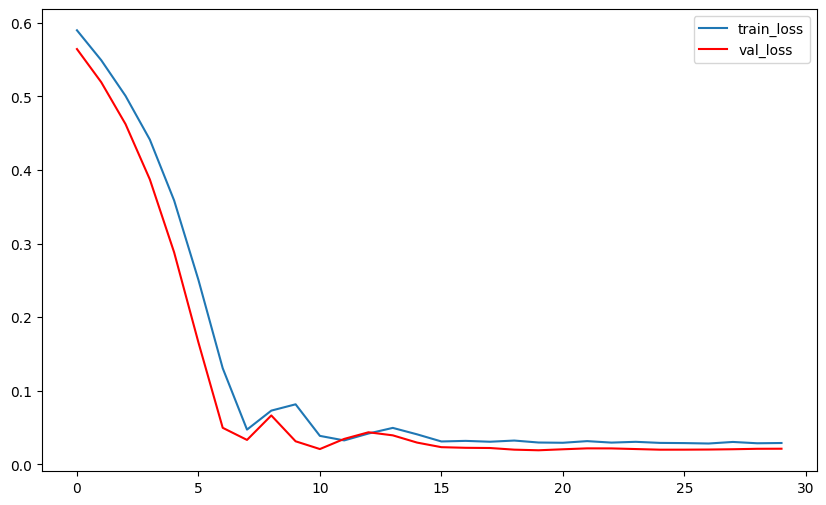

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], c='red', label='val_loss')
plt.legend();

In [19]:
y_pred = model.predict(X_test)

# Chuyển ngược dữ liệu về dạng gốc
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
temp_mae = float(mean_absolute_error(y_test[0], y_pred[0]))# compare with unnoise_dataset
print('Độ lệch trung bình của nhiet do thuc te so với nhiet do du bao là: {:.3f}'.format(temp_mae))
sal_mae = float(mean_absolute_error(y_test[1], y_pred[1]))# compare with unnoise_dataset
print('Độ lệch trung bình của do man thuc te so với do man du bao là: {:.3f}'.format(sal_mae))
pH_mae = float(mean_absolute_error(y_test[2], y_pred[2]))# compare with unnoise_dataset
print('Độ lệch trung bình của pH thuc te so với pH du bao là: {:.3f}'.format(pH_mae))

Độ lệch trung bình của nhiet do thuc te so với nhiet do du bao là: 0.112
Độ lệch trung bình của do man thuc te so với do man du bao là: 0.094
Độ lệch trung bình của pH thuc te so với pH du bao là: 0.073


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Tính MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 0.09521312899820072
MSE: 0.018024878765073606
RMSE: 0.13425676431775646
R2: -0.38050853063970097


In [22]:
dates = df_final.index[window_size:]
test_dates = dates[:test_size]

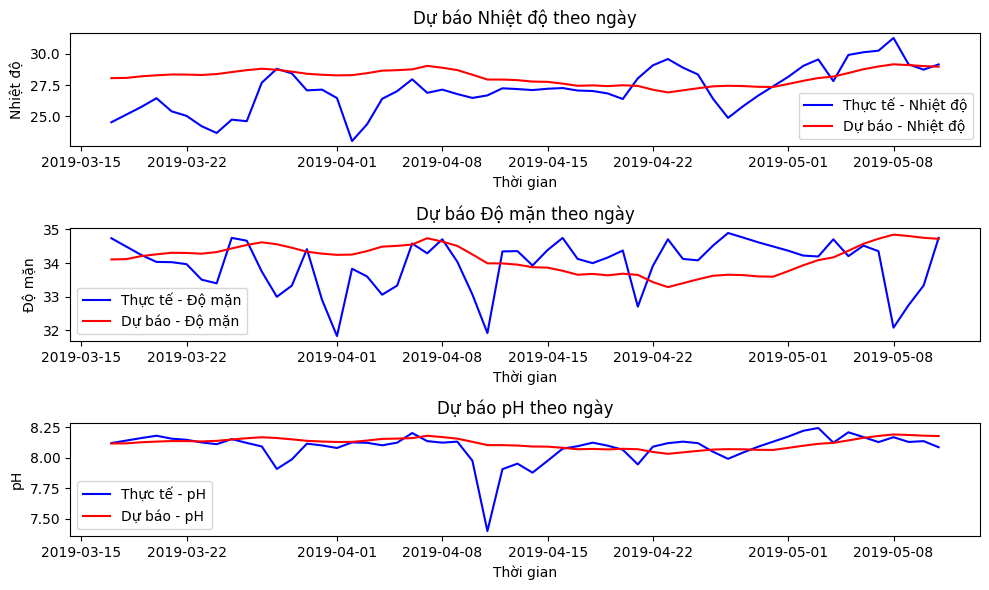

In [23]:
import matplotlib.pyplot as plt

# Vẽ đồ thị cho từng tham số
labels = ['Nhiệt độ', 'Độ mặn', 'pH']

plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    plt.subplot(3, 1, i + 1)
    plt.plot(test_dates, y_test_inverse[:, i], label=f'Thực tế - {labels[i]}', color='blue')
    plt.plot(test_dates, y_pred_inverse[:, i], label=f'Dự báo - {labels[i]}', color='red')
    plt.title(f'Dự báo {labels[i]} theo ngày')
    plt.xlabel('Thời gian')
    plt.ylabel(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

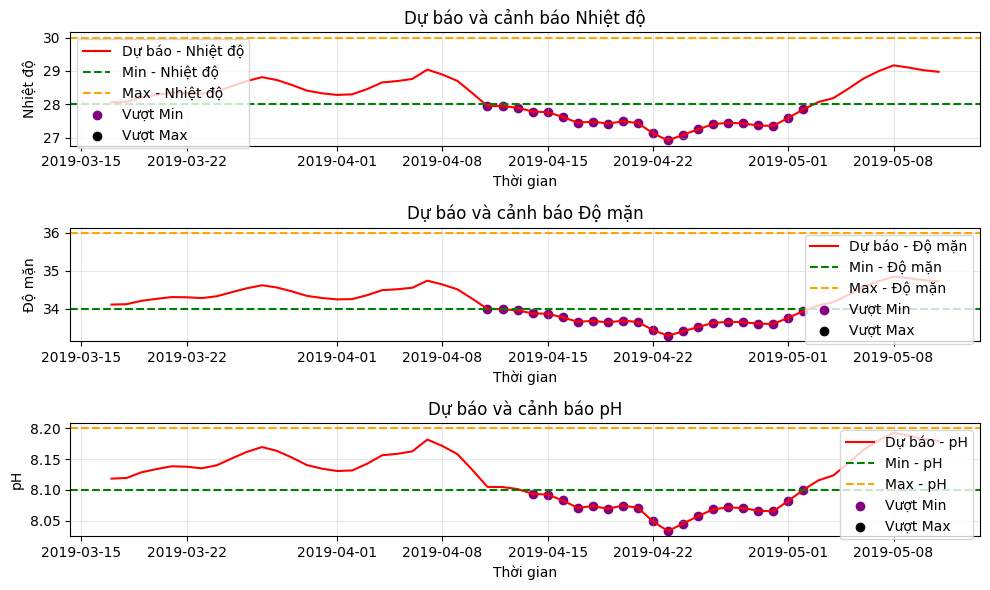

In [24]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = {
    "Nhiệt độ": {"min": 28, "max": 30},
    "Độ mặn": {"min": 34, "max": 36},
    "pH": {"min": 8.1, "max": 8.2}
}
labels = ["Nhiệt độ", "Độ mặn", "pH"]

plt.figure(figsize=(10, 6))

for i in range(len(labels)):
    min_val = thresholds[labels[i]]["min"]
    max_val = thresholds[labels[i]]["max"]

    # Vẽ đồ thị
    plt.subplot(3, 1, i + 1)
    plt.plot(test_dates, y_pred_inverse[:, i], label=f'Dự báo - {labels[i]}', color='red')

    # Vẽ ngưỡng
    plt.axhline(min_val, color='green', linestyle='--', label=f'Min - {labels[i]}')
    plt.axhline(max_val, color='orange', linestyle='--', label=f'Max - {labels[i]}')

    # Đánh dấu điểm vượt ngưỡng
    exceed_min = y_pred_inverse[:, i] < min_val
    exceed_max = y_pred_inverse[:, i] > max_val
    plt.scatter(test_dates[exceed_min], y_pred_inverse[exceed_min, i], color='purple', label='Vượt Min', zorder=1)
    plt.scatter(test_dates[exceed_max], y_pred_inverse[exceed_max, i], color='black', label='Vượt Max', zorder=1)

    # Thêm thông tin
    plt.title(f'Dự báo và cảnh báo {labels[i]}')
    plt.xlabel('Thời gian')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Hàm gửi email
def send_alert_email(subject, body, recipient_email):
    # Cấu hình email
    sender_email = "phuy19092002@gmail.com"  # Thay bằng email của bạn
    sender_password = "uswv vopv jbzb somj"     # Thay bằng mật khẩu của bạn

    # Tạo email
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = recipient_email
    msg['Subject'] = subject

    # Nội dung email
    msg.attach(MIMEText(body, 'plain'))

    # Gửi email
    try:
        with smtplib.SMTP('smtp.gmail.com', 587) as server:  # Sử dụng SMTP Gmail
            server.starttls()
            server.login(sender_email, sender_password)
            server.send_message(msg)
            print("Cảnh báo đã được gửi qua email.")
    except Exception as e:
        print("Lỗi khi gửi email:", e)

# Kiểm tra và gửi cảnh báo
for i in range(len(labels)):
    min_val = thresholds[labels[i]]["min"]
    max_val = thresholds[labels[i]]["max"]

    # Kiểm tra vi phạm
    exceed_min = y_pred_inverse[:, i] < min_val
    exceed_max = y_pred_inverse[:, i] > max_val

    if any(exceed_min) or any(exceed_max):
        # Tạo nội dung cảnh báo
        alert_body = f"""
        Dự báo vượt ngưỡng cho {labels[i]}:
        - Ngưỡng tối thiểu: {min_val}
        - Ngưỡng tối đa: {max_val}
        - Thời điểm vi phạm: {test_dates[exceed_min].tolist() if any(exceed_min) else test_dates[exceed_max].tolist()}
        """
        send_alert_email(
            subject=f"Cảnh báo: {labels[i]} vượt ngưỡng!",
            body=alert_body,
            recipient_email="recipient_email@example.com"
        )

Cảnh báo đã được gửi qua email.
Cảnh báo đã được gửi qua email.
Cảnh báo đã được gửi qua email.
